# AI/ML Project / Phase 2
## **Course Name**: Machine Learning Techniques  
## **Project Title**: Detecting AI-Generated Text  

---

### **Team Members**:
- Amr Kandil
- Lukas Donner
- Mohammed Chamsi   

---

### **Instructor**: Dr. Javier Montoya


# 1 - Overview

This phase builds upon the findings and progress made in the first phase of our project.

### Key Findings from Phase 1
- The dataset used was too small to match the complexity of the tested models.
- The variation of the text context was resulting in a "Data leakage" similar behaviour
- A larger dataset was required to achieve more accurate and reliable results.

### Phase 2 Objectives
To address the limitations identified, we:
1. **Extended the Dataset**:
   - Added the "AI vs Human Text" dataset, sourced from Kaggle.
   - This dataset provides additional data to match the required model complexity.
2. **Maintained Consistency**:
   - Data cleaning, preprocessing, and classification steps were implemented exactly as in Phase 1.


# 2 - Import Libraries

In [3]:
# !nvcc --version

In [4]:
# !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com


In [5]:
!pip install gdown
!pip install emoji
!pip install contractions

In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for creating visualizations such as bar plots and pie charts.
import seaborn as sns  # Import seaborn for enhanced data visualization, especially statistical plots.##
from google.colab import files
import zipfile
import gdown
import re  # Import the `re` module for performing regular expressions operations, useful for text cleaning and pattern matching.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import emoji  # Import the `emoji` library to handle emojis in text, including detecting and converting them to text representations.
import contractions  # Import the `contractions` library to expand shortened words in text (e.g., "can't" to "cannot"), improving readability and analysis.
import nltk # Import the nltk library
from nltk.corpus import stopwords  # Import the `stopwords` list from `nltk`, used to filter out common words (e.g., "and", "the") that may not add significant value.
from nltk.stem import WordNetLemmatizer  # Import the `WordNetLemmatizer` from `nltk` for reducing words to their base or root forms (e.g., "running" to "run").

# 3 - Connect to Kaggle
Whenever we use a Dataset from Kaggle, we load it directly from kaggle using the Kaggle API.

To load any Kaggle dataset, you need to first download Kaggle's beta API, and to accept the kaggle competition rules.

Get Kaggle API Credentials:
- Go to your Kaggle account settings and scroll to the API section.
- Click on Create New API Token. This will download a kaggle.json file containing your Kaggle API credentials.
- Then you need to upload the kaggle.json file to collab and run the following commands

In [ ]:
# upload your kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amrashrafkandil","key":"1d17ebbf21d4cea1c08abf3afbd3fdcd"}'}

In [7]:
# move the file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Make sure the kaggle.json file has the correct permissions
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# 4 - Dataset
This dataset can be found on Kaggle through the following link [AI vs Human Text](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text)

## Dataset Description
- The dataset consists of approximately **500,000 essays**, including:
  - Essays created by AI.
  - Essays written by humans.

## Data Collection Process
- Data was gathered from **multiple sources**.
- Duplicate entries were identified and removed to ensure dataset quality and uniqueness.



## 4.1 About Dataset
Around 500K essays are available in this dataset, both created by AI and written by Human.

I have gathered the data from multiple sources, added them together and removed the duplicates

## 4.2 Load Dataset From Phase 1

The final version of the dataset from Phase 1 was uploaded to Google Drive and made publicly accessible.

To use the dataset in this phase, we directly load it from the provided link.

In [8]:
file_id = "1X5hoiw6ZuoqNcobdgaa0f4iUGZH2Rdqp"
destination = "phase1_dataset.csv"  # Specify the file name after download
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


# Read the downloaded CSV file
df = pd.read_csv(destination)


Downloading...
From: https://drive.google.com/uc?id=1X5hoiw6ZuoqNcobdgaa0f4iUGZH2Rdqp
To: /content/phase1_dataset.csv
100%|██████████| 13.7M/13.7M [00:00<00:00, 113MB/s]


In [9]:
df

,id,prompt_id,text,generated,cleaned_text
0,0059830c,0,Cars. Cars have been around since they became ...,0,"cars. cars around since became famous s, henry..."
1,005db917,0,Transportation is a large necessity in most co...,0,transportation large necessity countries world...
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,americas love affair vehicles seems cooling sa...
3,00940276,0,How often do you ride in a car? Do you drive a...,0,often ride car? drive one motor vehicle work? ...
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,cars wonderful thing. perhaps one worlds great...
...,...,...,...,...,...
2773,1395,1,"Dear Senator,\n\nI am writing to express my su...",1,"dear senator, writing express support keeping ..."
2774,1396,1,"Dear State Senator,\n\nI am writing to express...",1,"dear state senator, writing express support ke..."
2775,1397,1,"Dear Senator,\n\nI am writing to you today to ...",1,"dear senator, writing today express support ke..."
2776,1398,1,"Dear Senator,\n\nI am writing to express my su...",1,"dear senator, writing express support retainin..."


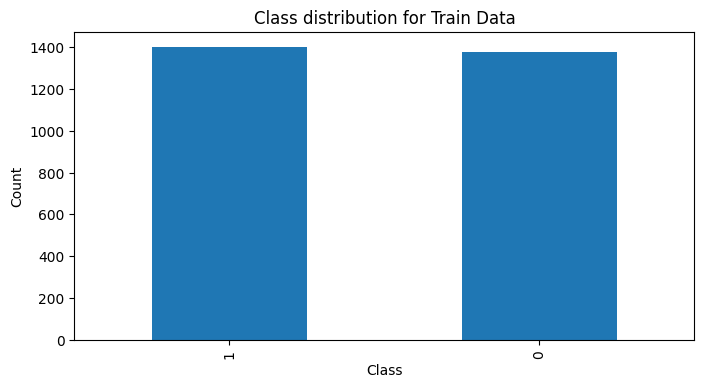

In [10]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.generated.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

## 4.3 Load AI_vs_Human_Text Dataset

In [11]:
BASE_PATH = '/content'

In [12]:
# Download the Dataset using the Kaggle API
!kaggle datasets download shanegerami/ai-vs-human-text

Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other
 99% 347M/350M [00:18<00:00, 15.1MB/s]
100% 350M/350M [00:18<00:00, 19.3MB/s]


In [13]:
# The Dataset is downloaded as .zip file, and it needs to be extracted
import zipfile
with zipfile.ZipFile('ai-vs-human-text.zip', 'r') as zip_ref:
    zip_ref.extractall('ai-vs-human-text')

## Load the new Data

In [14]:
df_new = pd.read_csv(f'{BASE_PATH}/ai-vs-human-text/AI_Human.csv')

In [15]:
df_new

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


In [16]:
# Add a new column for word count
df_new['word_count'] = df_new['text'].apply(lambda x: len(str(x).split()))

In [17]:
print(df_new['word_count'].describe())


count    487235.000000
mean        393.096214
std         168.593328
min           0.000000
25%         278.000000
50%         363.000000
75%         471.000000
max        1668.000000
Name: word_count, dtype: float64


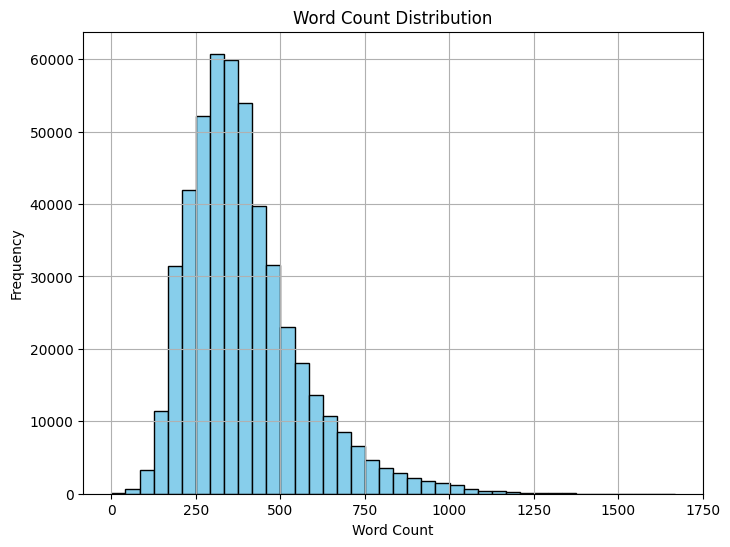

In [19]:
import matplotlib.pyplot as plt

df_new['word_count'].hist(bins=40, color='skyblue', edgecolor='black', figsize=(8, 6))
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [20]:
df_new['generated'] = df_new['generated'].astype(int)

In [21]:
df_new

,text,generated,word_count
0,Cars. Cars have been around since they became ...,0,584
1,Transportation is a large necessity in most co...,0,462
2,"""America's love affair with it's vehicles seem...",0,744
3,How often do you ride in a car? Do you drive a...,0,686
4,Cars are a wonderful thing. They are perhaps o...,0,871
...,...,...,...
487230,Tie Face on Mars is really just a big misunder...,0,192
487231,The whole purpose of democracy is to create a ...,0,385
487232,I firmly believe that governments worldwide sh...,1,360
487233,I DFN't agree with this decision because a LFT...,0,339


In [22]:
# Features to select from each DataFrame
features_result_df = ['text', 'generated']
features_df_new = ['text', 'generated']

# Select columns
result_df_selected = df[features_result_df]
df_new_selected = df_new[features_df_new]

# Concatenate the selected columns
result_df = pd.concat([result_df_selected, df_new_selected], ignore_index=True)

In [23]:
result_df

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
490008,Tie Face on Mars is really just a big misunder...,0
490009,The whole purpose of democracy is to create a ...,0
490010,I firmly believe that governments worldwide sh...,1
490011,I DFN't agree with this decision because a LFT...,0


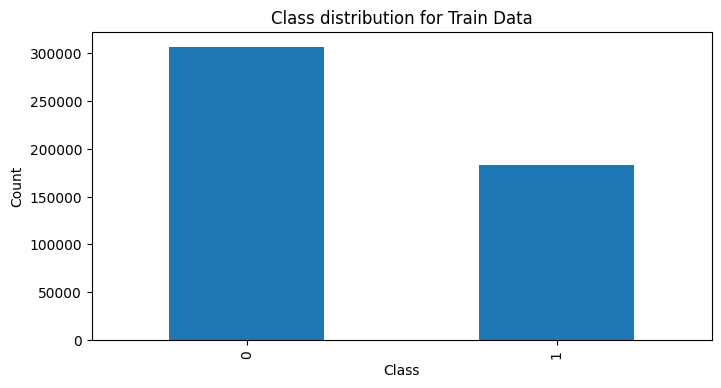

In [24]:
# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
result_df.generated.value_counts().plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

### Note

We can drop random 10k entries from the first class

In [25]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490013 entries, 0 to 490012
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       490013 non-null  object
 1   generated  490013 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.5+ MB


# 5 - Exploratory Data Analysis


## 5.1 - Missing Values

In [26]:
def func_missing_values(df):
    """
    Computes the number and percentage of missing values for each column in a pandas DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to analyze for missing values.

    Returns:
    DataFrame: A DataFrame containing the number of missing values and their percentages for each column.
    """

    # Calculate the total number of missing values for each column.
    missing_values =df.isnull().sum()

    # Retrieve the total number of rows (samples) in the DataFrame.
    nb_samples =df.shape[0]

    # Calculate the percentage of missing values for each column.
    missing_percent = missing_values/nb_samples

    # Create a DataFrame to store the missing values and their percentages for each column.
    missing_df = pd.DataFrame({'missing_values': missing_values, 'missing_percent': missing_percent })

    # Return the resulting DataFrame containing missing value information.
    return missing_df


In [27]:
# Call the `func_missing_values` function on the training DataFrame `df_train`.
df_train_missing = func_missing_values(result_df)  # Assign the result to `df_train_missing`

# Print the DataFrame to display the missing value statistics for the training dataset.
print(df_train_missing)

           missing_values  missing_percent
text                    0              0.0
generated               0              0.0


There are no missing values in the dataset

## 5.2 - Duplicate Values

In [28]:
def func_duplicate_values(df):
    """
    Identifies and computes the number and percentage of duplicate rows in a pandas DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to analyze for duplicate rows.

    Returns:
    DataFrame: A DataFrame containing the total number of duplicate rows and their percentage relative to the total number of rows in the input DataFrame.
    """

    # Count the total number of duplicate rows in the DataFrame.
    duplicate_values = df.duplicated().sum()

    # Get the total number of rows (samples) in the DataFrame.
    nb_samples = df.shape[0]

    # Calculate the percentage of duplicate rows relative to the total number of rows.
    duplicate_percent = duplicate_values / nb_samples

    # Create a DataFrame to store the number and percentage of duplicate rows.
    duplicate_df = pd.DataFrame({'duplicate_values': [duplicate_values], 'duplicate_percent': [duplicate_percent]})

    # Return the resulting DataFrame containing duplicate row information.
    return duplicate_df


In [29]:
df_train_duplicates =func_duplicate_values(result_df) # Call the `func_duplicate_values` function on the training DataFrame `df_train`.

print(df_train_duplicates)  #

   duplicate_values  duplicate_percent
0              1378           0.002812


There are no Duplicate values in the dataset

## 5.3 - Data Visualization

In [30]:
def func_plot_distribution(df, column_name='sentiment'):
    """
    Visualizes the distribution of values in a specified column of a DataFrame using a count plot and a pie chart.

    Parameters:
    df (DataFrame): The input DataFrame to analyze.
    column_name (str): The name of the column whose distribution will be visualized (default is 'sentiment').

    Returns:
    None: This function displays the visualizations directly using matplotlib.
    """

    # Create a figure with two subplots arranged horizontally
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

    # Add a main title to the entire figure
    fig.suptitle('Dataframe Distribution: {}'.format(column_name), fontsize=16, weight='bold')

    # Create a count plot on the first subplot
    ax0 = axs[0]  # Reference to the first subplot
    sns.countplot(data=df, x=column_name, ax=ax0, palette='viridis')
       # Plot a count plot of the column's values
    ax0.set_title('Count Plot', fontsize=14, weight='bold')  # Set the title for the count plot
    ax0.set_xlabel(column_name, fontsize=12)  # Label the x-axis with the column name
    ax0.set_ylabel('Count', fontsize=12)  # Label the y-axis as 'Count'
    ax0.tick_params(axis='x', labelsize=12)  # Adjust the size of x-axis labels
    ax0.tick_params(axis='y', labelsize=12)  # Adjust the size of y-axis labels
    ax0.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid to the y-axis for better readability

    # Create a pie chart on the second subplot
    ax1 = axs[1]  # Reference to the second subplot
    column_counts =df[column_name].value_counts() # Get the count of each unique value in the column
    colors = sns.color_palette('viridis', len(column_counts))  # Generate a color palette for the pie chart
    ax1.pie(column_counts, labels=column_counts.index, colors=colors, autopct='%1.1f%%')  # Plot the pie chart
    ax1.set_title('Pie Chart', fontsize=14, weight='bold')  # Set the title for the pie chart
    ax1.axis('equal')  # Ensure the pie chart is displayed as a perfect circle

    # Adjust the layout to prevent overlapping elements and display the plots
    plt.tight_layout()
    plt.show()

<ipython-input-30-f3e29f10798c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column_name, ax=ax0, palette='viridis')


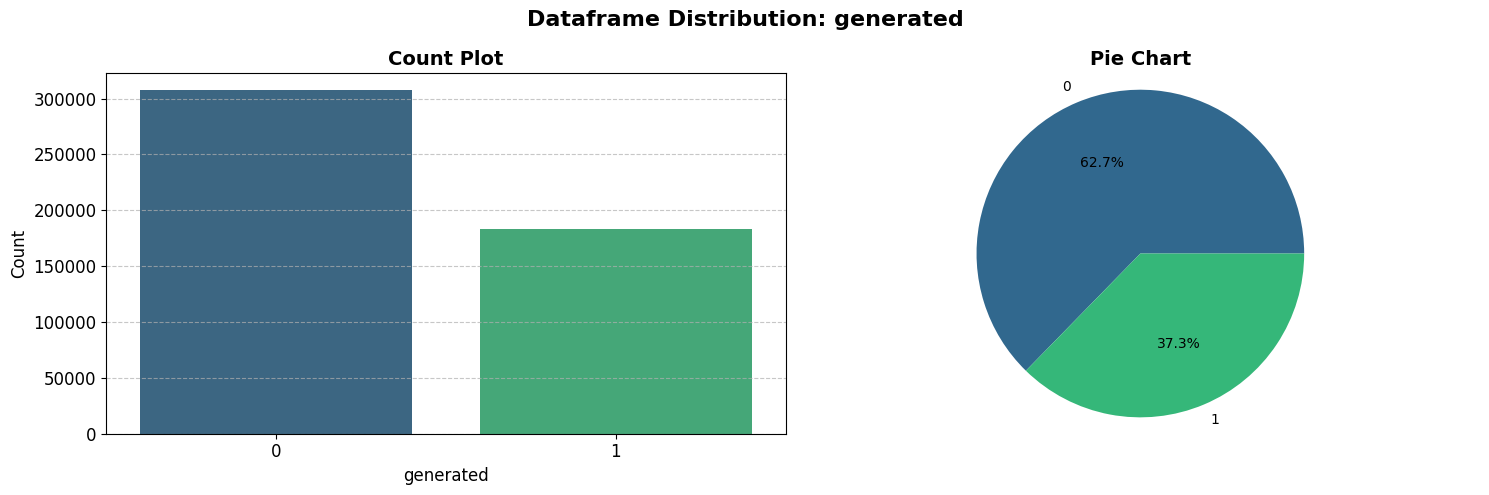

In [31]:
func_plot_distribution(result_df, column_name='generated')

# 6 - Data Preprocessing



> Data preprocessing ensures that the text data is clean, consistent, and in a format that machine learning models can process.







Data preprocessing is done in a multiple stages, including:
1.   Data Cleaning
  - removing special characters
  - removing emojis
  - removing URLs
  - leaving periods, qustion marks and exclamation marks
  - removing unneccassary white spaces
  - Expanding contractions
2.  Handling stop words
3.  Tokenization
4.  Vectorization (TFIDF)

## 6.1 - Data Cleaning
Data Cleaning involves:
- removing unwanted special characters
- unnecessary whitespaces
- irrelevant elements
  * URLs
  * Emojis
- Retaining periods, commas, question marks, and exclamation marks.

- The text is also converted to **lowercase** to ensure uniformity, helping the model interpret words correctly without case sensitivity issues.

In [32]:
def clean_text(text):
    """
    Cleans the text by removing unwanted characters while retaining periods, commas,
    question marks, and exclamation marks. Converts text to lowercase.
    """
    # Keep only letters, spaces, periods, commas, question marks, and exclamation marks
    text = re.sub(r"[^a-zA-Z\s.,!?]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove any URLs from the text.

    # Handle emojis
    text = emoji.demojize(text, delimiters=(" ", " "))  # Convert emojis to text descriptions if `demojize` is True.

    # Expand contractions
    text = contractions.fix(text)  # Replace contractions with their expanded form (e.g., "can't" -> "cannot").

    # Convert to lowercase
    return text.lower()



# Apply the cleaning function to the 'text' column
result_df['cleaned_text'] = result_df['text'].apply(clean_text)

# Preview the cleaned text
print(result_df[['text', 'cleaned_text']].head())


                                                text  \
0  Cars. Cars have been around since they became ...   
1  Transportation is a large necessity in most co...   
2  "America's love affair with it's vehicles seem...   
3  How often do you ride in a car? Do you drive a...   
4  Cars are a wonderful thing. They are perhaps o...   

                                        cleaned_text  
0  cars. cars have been around since they became ...  
1  transportation is a large necessity in most co...  
2  americas love affair with its vehicles seems t...  
3  how often do you ride in a car? do you drive a...  
4  cars are a wonderful thing. they are perhaps o...  


## 6.2 - Handling Stop-Words

- Stopwords like "and," "is," or "the" can often be irrelevant for the task, but their removal depends on the problem.
- For classification tasks focusing on semantics, retaining them may help, especially if they contribute to the context.

In [33]:
# Download stopwords if not already available
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [34]:

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()  # Split the text into individual words (tokens).
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)  # Combine the cleaned tokens back into a single string.

# Remove stopwords
result_df['cleaned_text'] = result_df['cleaned_text'].apply(remove_stopwords)

# Preview tokens after stopword removal
print(result_df[['cleaned_text']].head())


                                        cleaned_text
0  cars. cars around since became famous s, henry...
1  transportation large necessity countries world...
2  americas love affair vehicles seems cooling sa...
3  often ride car? drive one motor vehicle work? ...
4  cars wonderful thing. perhaps one worlds great...


In [ ]:
# # Store the combined df to a csv file for later analysis in phase 2

# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/HSLU/ML&DS/Group3/Project/data/phase2_dataset_final_cleaned.csv'  # Replace with your desired path

# result_df.to_csv(file_path, index=False)  # index=False prevents writing row indices to the CSV

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # prompt: how to load and read a csv file from /content


# # Assuming your CSV file is named 'your_file.csv' and is located in /content
# file_path = '/content/phase2_dataset_final_cleaned.csv'


# result_df = pd.read_csv(file_path)


ParserError: Error tokenizing data. C error: EOF inside string starting at row 249361

In [35]:
result_df

,text,generated,cleaned_text
0,Cars. Cars have been around since they became ...,0,"cars. cars around since became famous s, henry..."
1,Transportation is a large necessity in most co...,0,transportation large necessity countries world...
2,"""America's love affair with it's vehicles seem...",0,americas love affair vehicles seems cooling sa...
3,How often do you ride in a car? Do you drive a...,0,often ride car? drive one motor vehicle work? ...
4,Cars are a wonderful thing. They are perhaps o...,0,cars wonderful thing. perhaps one worlds great...
...,...,...,...
490008,Tie Face on Mars is really just a big misunder...,0,tie face mars really big misunderstanding. str...
490009,The whole purpose of democracy is to create a ...,0,whole purpose democracy create government refl...
490010,I firmly believe that governments worldwide sh...,1,firmly believe governments worldwide take imme...
490011,I DFN't agree with this decision because a LFT...,0,dfnt agree decision lft ff kids may nft want t...


# 7 - Feature Extraction
Text must be converted into numerical format to feed into machine learning models.

Popular techniques include
- Bag of Words (BoW)
- TF-IDF for statistical representation
- Word Embeddings
  * like Word2Vec, GloVe
  * or Contextual embeddings (like BERT) for semantic representations.
  
These methods capture word importance, relationships, or context, enabling models to make more accurate predictions.


---



In this Notebook we will explore two methods:
1. TF-IDF
2. Contexual Embeddings with BERT
  - This will be explained and implemented in section 9.2 of the notebook


## 7.1 Text Vectorization (TF-IDF)

#### Explanation of Parameters

- **`lowercase=True`**: Converts all text to lowercase.

- **`stop_words='english'`**: Removes common English stopwords.

- **`token_pattern`**:
  - The default regex (`r"(?u)\b\w\w+\b"`) matches tokens of 2 or more characters.
  - The adjusted regex (`r"(?u)\b\w+\b"`) includes single-character tokens, which can be important for retaining punctuation marks like `.` or `?`.

- **`ngram_range=(1, 1)`**: Specifies unigrams (individual words). You can adjust to include bigrams (`(2, 2)`) or a range (`(1, 2)`).

- **`max_features=5000`**: Limits the number of tokens to the top 5,000 by TF-IDF score. Remove this parameter if you don't want a limit.


In [36]:
# Define the custom vectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,                   # Convert text to lowercase
    stop_words='english',             # Remove stopwords
    token_pattern=r"(?u)\b\w+\b",     # Tokenization pattern to match words
    ngram_range=(1, 1),               # Use unigrams (single words); adjust for n-grams
    max_features=100                 # Limit the number of features (optional)
)

# Apply the vectorizer to your cleaned text column
# X_tfidf = vectorizer.fit_transform(combined_df['text'])
X_tfidf = vectorizer.fit_transform(result_df['cleaned_text'])

# Get the feature names (tokens) generated by the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Print the feature names and TF-IDF matrix
print("Feature names:", feature_names[:10])  # Show first 10 tokens
print("TF-IDF matrix shape:", X_tfidf.shape)


Feature names: ['able' 'activities' 'advice' 'air' 'article' 'author' 'believe'
 'benefits' 'best' 'better']
TF-IDF matrix shape: (490013, 100)


In [37]:
X_tfidf

<490013x100 sparse matrix of type '<class 'numpy.float64'>'
	with 9226011 stored elements in Compressed Sparse Row format>

The output of `TfidfVectorizer` is a **sparse matrix** where each row represents a document (in your case, a piece of text), and each column corresponds to a token (word or n-gram) extracted during the vectorization process. The values in this matrix represent the **TF-IDF scores** for each token in each document.

---

#### **Breaking Down the Output**

#### **1. Sparse Matrix**
The output is a sparse matrix of shape `(n_samples, n_features)`, where:
- `n_samples` = Number of documents (rows in your dataset).
- `n_features` = Number of unique tokens (columns, also called the vocabulary size).

For example, if you have 5 text samples and the vectorizer identifies 10 unique tokens, the matrix shape will be `(5, 10)`.

#### **2. TF-IDF Scores**
Each value in the matrix is the **TF-IDF score** for a specific token in a specific document. This score indicates the importance of the token in that document relative to the entire corpus.

**TF-IDF Formula:**

TF-IDF(t, d) = TF(t, d) * IDF(t)


- **Term Frequency (TF):** How often a term `t` appears in a document `d`, normalized by the total number of terms in `d`:

TF(t, d) = (count of t in document d) / (total terms in document d)


- **Inverse Document Frequency (IDF):** Measures how unique a term is across all documents. It is calculated as:

IDF(t) = log(N / (1 + n_t))


Where:
- `N` is the total number of documents.
- `n_t` is the number of documents containing the term `t`.

#### **3. Feature Names**
The vectorizer also provides the names of the tokens (features) it extracted. You can get them using:



```
feature_names = vectorizer.get_feature_names_out()
```




# 8 - Train/Test Data Split

The vectorized data (data in their numerical form) resulting from the previous section are split into Training and test datasets with a reation of 70% to 30% respectively

The split Function recieves the:
- Features: X_tfidf => sparse matrix generated after vecorization
- Lables: result_df['generated'] => the label from the original Dataset

In [38]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,                   # Feature matrix from TfidfVectorizer
    result_df['generated'],         # Target labels (0 = human, 1 = AI-generated)
    test_size=0.3,             # 30% of the data for testing
    random_state=42,           # For reproducibility
    stratify=result_df['generated'] # Maintain class distribution
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (343009, 100)
Test set shape: (147004, 100)


# 9 - Classification

Download Cuml in order to be able to run on the GPU.

## 9.1 - Classical Machine Learning

### 9.1.1 - Logistic Regression

In [ ]:
# Initialize the logistic regression model
model = LogisticRegression(max_iter=50, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)


# Calculate accuracies
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 88.96%
Test Accuracy: 89.01%


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8900710184756877

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     92152
           1       0.88      0.82      0.85     54852

    accuracy                           0.89    147004
   macro avg       0.89      0.87      0.88    147004
weighted avg       0.89      0.89      0.89    147004



Confusion Matrix:
 [[86112  6040]
 [10120 44732]]


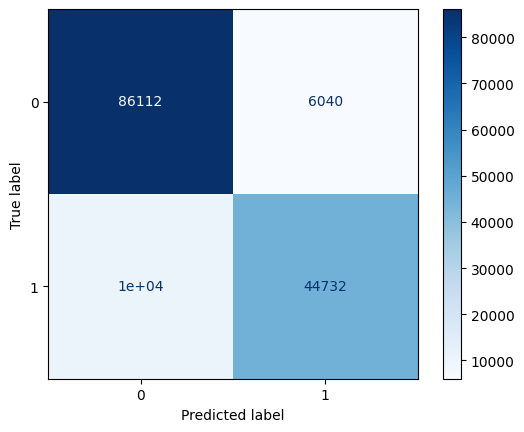

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the raw confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')  # Adjust `cmap` for a color scheme


### 9.1.2 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Calculate accuracies
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Print classification report for detailed metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

### 9.1.3 - KNNs

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize KNN with k=5
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine', weights='uniform')

# Train the model
knn_model.fit(X_train, y_train)

In [ ]:
# Make predictions on training and test data
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

# Perform grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap='Blues')
plt.show()



### 9.1.4 - SVMs



In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=1, random_state=42) # linear kernel, Gamma = 1

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
train_acc_svm = accuracy_score(y_train, svm_model.predict(X_train))
test_acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Training Accuracy: {train_acc_svm * 100:.2f}%")
print(f"SVM Test Accuracy: {test_acc_svm * 100:.2f}%")

print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:\n", cm_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_svm.plot(cmap='Blues')
plt.show()

In [ ]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:\n", cm_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_svm.plot(cmap='Blues')
plt.show()

## 9.2 - Neural Networks

In this section, we classify text using a deep learning approach, which is going to be different than the previous approaches in:
- The Data representation
- The Classification Algorithm

### Key Difference in Data Representation
The primary distinction between this approach and the previous one lies in how we represent text data numerically (feature extraction). Previously, we used **TF-IDF (Term Frequency-Inverse Document Frequency)**, a statistical representation of text. While TF-IDF performed well for our use case, it has a limitations. It fails to capture the context and semantics of the text, as it treats each word independently and disregards word order or meaning.

### Vector Embeddings for Semantic Representation
To overcome these limitations, we use **vector embeddings**, a more sophisticated method of text representation.

**Vector embeddings** are dense, fixed-length representations of text where semantically similar pieces of text are closer in the vector space. These embeddings capture rich contextual and semantic information, making them particularly suitable for downstream tasks like classification.

We generate these embeddings by passing the text through a **large language model (LLM)** optimized for embedding generation. Some examples of such models include:
- **BERT (Bidirectional Encoder Representations from Transformers)**: Captures context from both directions (left and right).
- **DistilBERT**: A smaller, faster, and efficient version of BERT with minimal performance loss.
- **RoBERTa**: A robustly optimized version of BERT.

### Classification Using Neural Networks
Once we obtain the embeddings, we can approach classification in two ways:
1. Using classical statistical machine learning methods, such as logistic regression or support vector machines (SVM).
2. Using a neural network with a binary classification output head.





### 9.1 - Our Chosen Approach

For this project, we chose the second approach, as it offers the potential to better leverage the rich contextual information encapsulated in the embeddings.

### Why BERT for Embeddings?
We decided to use **BERT** for generating embeddings because of its proven effectiveness in capturing semantic and contextual information. BERT is pre-trained on a massive corpus of text and excels in transfer learning, making it suitable for our use case.

Additionally, BERT offers a variety of implementations including **DistilBERTForSequenceClassification**, which we decided to work with in our approach because it:
- Reduces the computational overhead compared to the full BERT model.
- Comes with a pre-defined classification head, simplifying our implementation process.



By leveraging this deep learning approach, we aim to achieve a more accurate classification performance compared to traditional statistical methods.

---

### Architecture

**DistilBERTForSequenceClassification** consists of two parts:
- Core Pretrained Distil BERT model
- A pre-designed MLP classification head for classifcation

We are going to freeze the




#### Steps to Modify and Fine-Tune BERT for Text Classification
1. The Pretrained Distil-BERT Model generates embeddings, which will be fed into a classification head.
2. The Classification Layer is a simple fully connected (dense) layer on top of BERT's pooled output (token embedding) for binary classification.
3. Parameters of Distil-BERT Layers are freezed. We Only train  the classification layer.
4. Train on Your Dataset: Train the model using the labeled dataset

In [ ]:
! pip install datasets

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import re

In [ ]:
# Split into train and test
texts = result_df['cleaned_text']
labels = result_df['generated']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


### 9.2 - Tokenization

We use the **DistilBERT Tokenizer** to convert text into token IDs suitable for the DistilBERT model.

- **Tokenizer**: `DistilBertTokenizer.from_pretrained('distilbert-base-uncased')`
- **Tokenization Parameters**:
  - `max_length=128`: Maximum token length.
  - `padding="max_length"`: Pads sequences to the maximum length.
  - `truncation=True`: Truncates sequences longer than `max_length`.

---

In [ ]:
# 3. **Tokenization using BERT Tokenizer**
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding='max_length', truncation=True, max_length=128)

### 9.3 - Dataset Preprocessing

The `TextDataset` class is preprocess the text datset before it is passed to the Bert model.
It performs the following key functions:



In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch

In [ ]:


# Step 1: Define a custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

### 9.4 - Loading  Model and Training

In [ ]:
# Load pre-trained Distil-BERT model with classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:


# Freeze the parameters of BERT model (only classification head will be trained)
for param in model.distilbert.parameters():
    param.requires_grad = False

#  Prepare dataset and dataloader
texts = X_train
labels = y_train

dataset = TextDataset(texts, labels, tokenizer, max_len=128)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#  Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-3)
loss_fn = CrossEntropyLoss()

#  Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):  # Number of epochs
    model.train()
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Classification loss
        logits = outputs.logits  # Predicted scores

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Step 6: Save the fine-tuned model
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")


In [ ]:
# Load the fine-tuned model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("./fine_tuned_bert")
model = DistilBertForSequenceClassification.from_pretrained("./fine_tuned_bert")

# Test with a new example
text = "This is a test of the fine-tuned model."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
print(f"Prediction: {'AI' if predictions.item() == 1 else 'Human'}")


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
texts = X_test
labels = y_test

dataset = TextDataset(texts, labels, tokenizer, max_len=128)
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


# Step 2: Load the fine-tuned model
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = DistilBertTokenizer.from_pretrained("./fine_tuned_bert")

# Step 3: Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass to get predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)  # Get class predictions

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 4: Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


### 9.5 Notes

trainning the model on Collab required a lot of time and we had to leave it running overnight.

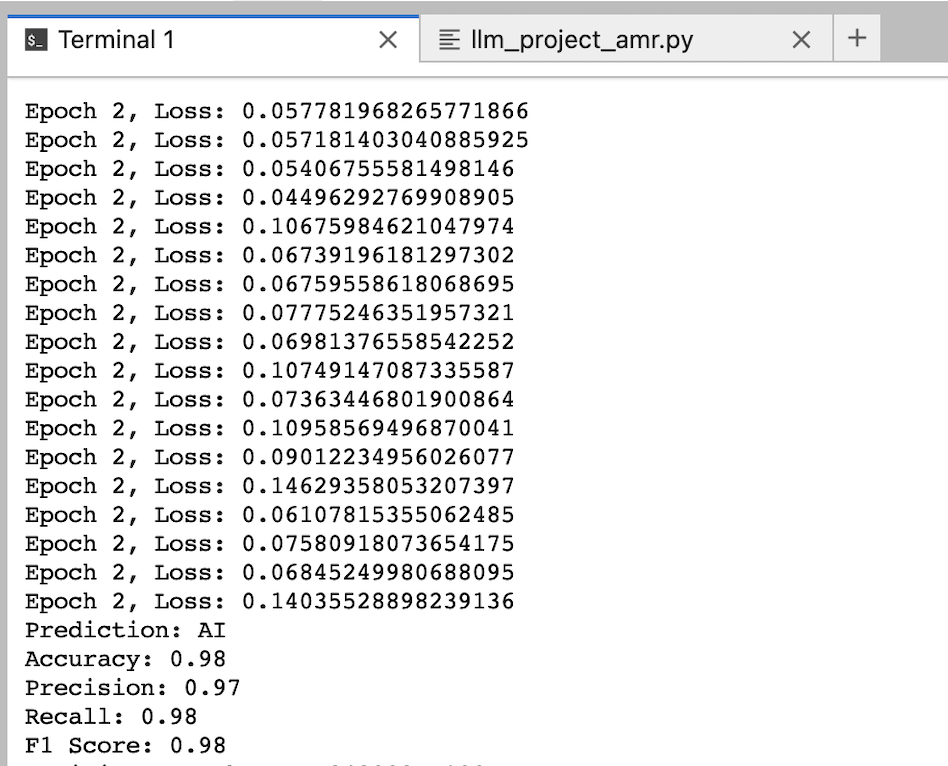

## Test Accuracy

# 10 - Analysis

### Notes


- very high accuracies
- dataset is small
- data leakage is happening


## Suggestions
- redo the prompt engineering making the LLM only read one or two source texts not all of them
- add more prompts
  - but we will not be able to balance it with human generated text
- expand the dataset
